In [1]:
import torch,torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
from model import Generator, iterate_minibatches, compute_loss, train


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
OCTAVE_NUM = 4
NOTE_NUM = 12
TIME_SCALE = 128


class LSTM_discriminator(nn.Module):
    def __init__(self,hidden_size = 1000,last_dim = 3):
        super(self.__class__, self).__init__()
        self.last_dim = last_dim
        self.hidden_size = hidden_size
        self.note_lstm = nn.LSTM(input_size = OCTAVE_NUM*last_dim,hidden_size = hidden_size)
        self.time_lstm = nn.LSTM(input_size = hidden_size,hidden_size = hidden_size)
        self.dense = nn.Linear(hidden_size,1)

    def forward(self,data):
        # data.size() =  (batch_size, TIME_SCALE, NOTE_NUM*OCTAVE_NUM, last_dim)
        # octave_data.size() =  (batch_size, TIME_SCALE, NOTE_NUM,OCTAVE_NUM*last_dim)
        batch_size,_,_,_ = data.size()
        octave_data = data.view(batch_size,TIME_SCALE,NOTE_NUM,OCTAVE_NUM,self.last_dim)\
                          .view(batch_size,TIME_SCALE,NOTE_NUM,OCTAVE_NUM*self.last_dim)
            
        # note_lstm_input.size() = (NOTE_NUM, batch_size*TIME_SCALE,OCTAVE_NUM*last_dim)
        note_lstm_input = octave_data.view(batch_size*TIME_SCALE,NOTE_NUM,OCTAVE_NUM*self.last_dim)\
                                     .transpose(0,1)
        # note_lstm_output.size() = (NOTE_NUM,batch_size*TIME_SCALE,hidden_size)
        note_lstm_output, _ = self.note_lstm(note_lstm_input)
        # time_lstm_input.size() = (TIME_SCALE,batch_size,hidden_size)
        time_lstm_input = note_lstm_output[-1].view(batch_size,TIME_SCALE,self.hidden_size)\
                                          .transpose(0,1)\
        # time_lstm_output.size() = (TIME_SCALE,batch_size,1000)
        time_lstm_output, _  = self.time_lstm(time_lstm_input)
        # dense_input.size() = (batch_size,1000)
        dense_input = time_lstm_output[-1]
        # dense_output.size() = (batch_size,1)
        dense_output = self.dense(dense_input)
        probs = F.sigmoid(dense_output)
        return probs
        
        
        

In [3]:
# device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")
# # device = torch.device("cpu")
# discriminator = LSTM_discriminator(hidden_size=10).to(device)
# np_data = np.random.randn(10,TIME_SCALE,NOTE_NUM*OCTAVE_NUM,3)
# data = torch.FloatTensor(np_data).to(device)
# discriminator(data)

In [4]:
class LSTM_baseline(nn.Module):
    def __init__(self,hidden_size = 1000):
        super(self.__class__, self).__init__()
        self.hidden_size = hidden_size
        self.note_lstm = nn.LSTM(input_size = OCTAVE_NUM*3,hidden_size = hidden_size)
        self.time_lstm = nn.LSTM(input_size = hidden_size,hidden_size = hidden_size)
        self.dense = nn.Linear(hidden_size,1)

    def forward(self,data,_):
        # data.size() =  (batch_size, TIME_SCALE, NOTE_NUM*OCTAVE_NUM, 3)
        # octave_data.size() =  (batch_size, TIME_SCALE, NOTE_NUM,OCTAVE_NUM*3)
        batch_size,_,_,_ = data.size()
        octave_data = data.view(batch_size,TIME_SCALE,NOTE_NUM,OCTAVE_NUM,3)\
                          .view(batch_size,TIME_SCALE,NOTE_NUM,OCTAVE_NUM*3)
            
        # note_lstm_input.size() = (NOTE_NUM, batch_size*TIME_SCALE,OCTAVE_NUM*3)
        note_lstm_input = octave_data.view(batch_size*TIME_SCALE,NOTE_NUM,OCTAVE_NUM*3)\
                                     .transpose(0,1)
        # note_lstm_output.size() = (NOTE_NUM,batch_size*TIME_SCALE,hidden_size)
        note_lstm_output, _ = self.note_lstm(note_lstm_input)
        # time_lstm_input.size() = (TIME_SCALE,batch_size,hidden_size)
        time_lstm_input = note_lstm_output[-1].view(batch_size,TIME_SCALE,self.hidden_size)\
                                          .transpose(0,1)\
        # time_lstm_output.size() = (TIME_SCALE,batch_size,1000)
        time_lstm_output, _  = self.time_lstm(time_lstm_input)
        # dense_input.size() = (batch_size,1000)
        dense_input = time_lstm_output[-1]
        # dense_output.size() = (batch_size,1)
        dense_output = self.dense(dense_input)
        probs = F.sigmoid(dense_output)
        return probs

In [5]:
# discriminator = LSTM_baseline(hidden_size=1000).to(device)
# np_data = np.random.randn(10,TIME_SCALE,NOTE_NUM*OCTAVE_NUM,3)
# data = torch.FloatTensor(np_data).to(device)
# discriminator(data)

In [6]:
class BasicGenerator(nn.Module):
    def __init__(self,hidden_size = 1000):
        super(self.__class__, self).__init__()
        self.dense_in = nn.Linear(TIME_SCALE*NOTE_NUM*OCTAVE_NUM*3,hidden_size)
        self.dense_out = nn.Linear(hidden_size,TIME_SCALE*NOTE_NUM*OCTAVE_NUM*3)

    def forward(self,data,_):
        batch_size,_,_,_ = data.size()
        data = data.view(batch_size,-1)
        hid_data = self.dense_in(data)
        out_data = self.dense_out(hid_data)
        output = F.sigmoid(out_data.view(batch_size, TIME_SCALE, NOTE_NUM*OCTAVE_NUM, 3))
        return output
        

In [7]:
class BasicDiscriminator(nn.Module):
    def __init__(self,hidden_size = 1000, last_dim = 3):
        super(self.__class__, self).__init__()
        self.dense_in = nn.Linear(TIME_SCALE*NOTE_NUM*OCTAVE_NUM*last_dim,hidden_size)
        self.dense_out = nn.Linear(hidden_size,1)

    def forward(self,data):
        batch_size,_,_,_ = data.size()
        data = data.view(batch_size,-1)
        hid_data = self.dense_in(data)
        out_data = self.dense_out(hid_data)
        output = F.sigmoid(out_data)
        return output

In [8]:
def g_loss(p_fake,sound,in_probs,baseline_pred,y_true,eps = 1e-8):

    gen_confidence = sound[:,:,:,:2]*in_probs[:,:,:,:2]\
            +(1-sound[:,:,:,:2])*(1-in_probs[:,:,:,:2])

    print('p_fake: ',p_fake.mean().cpu().data.numpy(),'probs: ',gen_confidence.mean().cpu().data.numpy())
    return -((gen_confidence+eps).log().sum(dim =-1).sum(dim =-1).sum(dim =-1)*(p_fake-baseline_pred)).mean()
def d_loss(p_fake, p_true,eps = 1e-8):

    return -(1-p_fake+eps).log().mean()-(p_true+eps).log().mean()
    
def bl_loss(bl_pred,real_reward):
    return (bl_pred-real_reward).pow(2).mean()



In [32]:
import torch.utils.data

def sample_sound(data_gen):
    size = data_gen.size()
    rand = torch.rand(*size).cuda()
    sample = (rand<data_gen).type(torch.FloatTensor).cuda()
#     sample[:,:,:,2] = data_gen[:,:,:,2]
    sample[:,:,:,2] = 1
    return sample
 
import torch.utils.data

    

def train_GAN(generator,discriminator,baseline,X_loader,num_epochs = 3,g_lr = 0.001, d_lr = 0.001,bl_lr = 0.001):
    generator.train()
    discriminator.train()
    g_optimizer = torch.optim.Adam(generator.parameters(),     lr=g_lr,weight_decay = 0)#, betas=(0.5, 0.999))
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=d_lr,weight_decay = 0)#, betas=(0.5, 0.999))
    bl_optimizer = torch.optim.Adam(baseline.parameters(), lr=bl_lr)
    
    d_losses = []
    g_losses = []
    bl_losses = []
    for epoch in range(num_epochs):
        for x_batch,ch_batch in X_loader:
            x_batch = x_batch.cuda()
            ch_batch = ch_batch.cuda()
            x_batch[:,:,:,2] = 1
            ch_batch[:,:,:,2] = 1
            generator.train()
            # Optimize D

#             data_gen = generator(x_batch,ch_batch)
#             sound = sample_sound(data_gen).data
# #             sound[:,:,:,1] = sound[:,:,:,1]*sound[:,:,:,0]
#             #concat_sound = torch.cat([x_batch[:,1:TIME_SCALE//2+1,:,:],sound[:,TIME_SCALE//2:,:,:]],dim = 1)
#             false_example = torch.cat([sound,x_batch],dim = -1)
#             true_example = torch.cat([ch_batch,x_batch],dim = -1)
#             loss = d_loss(discriminator(false_example), discriminator(true_example))
#             d_optimizer.zero_grad()
#             loss.backward()
# #             print(loss.grad)
#             d_optimizer.step()
#             d_losses.append(loss.data.cpu().numpy())
        
#             # Optimize BL
#             data_gen = generator(x_batch,ch_batch)
#             sound = sample_sound(data_gen).data
# #             sound[:,:,:,1] = sound[:,:,:,1]*sound[:,:,:,0]
#             false_example = torch.cat([sound,x_batch],dim = -1)
#             loss = bl_loss(baseline(x_batch,ch_batch),discriminator(false_example))
#             bl_optimizer.zero_grad()
#             loss.backward()
#             bl_optimizer.step()
#             bl_losses.append(loss.data.cpu().numpy())
            
#             # Optimize G
            
            data_gen = generator(x_batch,ch_batch)
#             sound = sample_sound(data_gen).data
# #             sound[:,:,:,1] = sound[:,:,:,1]*sound[:,:,:,0]
#             #concat_sound = torch.cat([x_batch[:,1:TIME_SCALE//2+1,:,:],sound[:,TIME_SCALE//2:,:,:]],dim = 1)
    
#             false_example = torch.cat([sound,x_batch],dim = -1)
#             true_example = torch.cat([ch_batch,x_batch],dim = -1)
#             handle = np.random.randint(0,2)
# #             if handle == 0:
# #                 loss = g_loss(discriminator(false_example),sound,data_gen,baseline(x_batch,ch_batch),ch_batch)#,sound.data,data_gen)
# #             else:
# #                 loss = g_loss(discriminator(true_example),ch_batch,data_gen,baseline(x_batch,ch_batch),ch_batch)#,sound.data,data_gen)
            g_optimizer.zero_grad()
            loss = compute_loss(data_gen,ch_batch)
            loss.backward()
#             print(loss.grad)
            g_optimizer.step()
            g_losses.append(loss.data.cpu().numpy())
    return generator,discriminator,baseline,np.array(g_losses),np.array(d_losses),np.array(bl_losses)

In [44]:
from dataset import load_all
from constants import *

styles= [['data/Bach1']]
train_data, train_labels = load_all(styles, BATCH_SIZE, TIME_SCALE)
N = 5000
X_tr = train_data[0][:N]
y_tr = train_labels[0][:N]
# X_te = train_data[0][N:2*N]
train_data[0].shape,y_tr.shape,N
#y_te = train_labels[0][-1:]

((81, 128, 48, 3), (81, 128, 48, 3), 5000)

In [40]:
X_loader = torch.utils.data.DataLoader(\
            torch.utils.data.TensorDataset(\
            *(torch.FloatTensor(X_tr),
            torch.FloatTensor(y_tr))),\
            batch_size=1,shuffle=True)


In [28]:
import gc
with torch.cuda.device(GPU):
    torch.cuda.empty_cache()
    gc.collect() 

In [42]:
GPU = 2
with torch.cuda.device(GPU):
    # device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")
    #device = torch.device("cpu")
    generator = Generator().cuda()
    discriminator = LSTM_discriminator(hidden_size=1000,last_dim=6).cuda()
#     # generator = BasicGenerator().cuda()
    baseline = LSTM_baseline(hidden_size=1000).cuda()
    #discriminator = BasicDiscriminator(last_dim=6).cuda()
    generator,discriminator,baseline,g_losses,d_losses,bl_losses =\
                    train_GAN(generator,discriminator,baseline,\
                            X_loader,num_epochs = 10, g_lr = 1*1e-3,d_lr=1*1e-2, bl_lr = 1*1e-4)

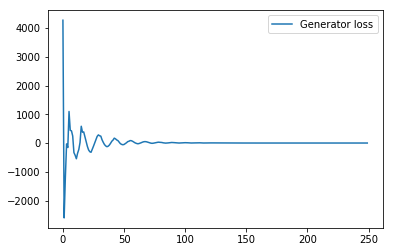

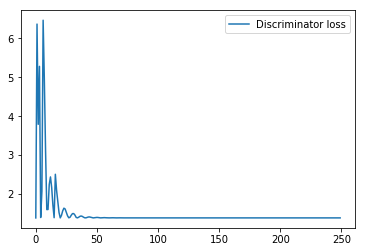

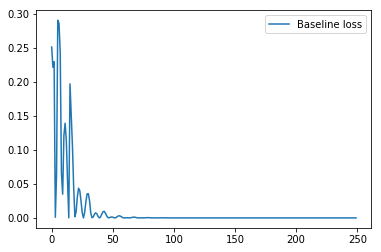

In [17]:
import matplotlib.pyplot as plt
plt.plot(g_losses,label = "Generator loss")
plt.legend()
plt.show()
plt.plot(d_losses,label = "Discriminator loss")
plt.legend()
plt.show()
plt.plot(bl_losses,label = "Baseline loss")
plt.legend()
plt.show()

In [43]:
from generate import write_file, generate
# import gc
# torch.cuda.empty_cache()
# gc.collect() 
with torch.cuda.device(GPU):
    write_file('output/canonical_test', generate(generator, 4))

  2%|▏         | 1/64 [00:00<00:07,  8.98it/s]

Generating with no styles:


100%|██████████| 64/64 [00:07<00:00,  8.36it/s]

Writing file out/samples/output/canonical_test_0.mid
